In [1]:
#Importando bibliotecas importantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import os
import locale

In [2]:
#Setando o local para o Brasil
locale.setlocale(locale.LC_ALL, "pt_br")

#Criando o dataframe que vai receber os dados das ações novas
df_new = pd.read_csv('Novo.csv', sep=';')
df_new.head()

,Identificador,Título (O que?),Início,Término,Duração,Nome,Área,Função,Agrupador
0,3,Elaboração e execução de uma nova qualificação...,24/02/2023,30/05/2025,591,Valentina Araújo Santos,Departamento 3,Analista PL - Analista PL,PL-I-QUA-ASQ-000027 - RELPH-000014 LAVADORA - ...
1,1,Elaboração da analise de risco e matriz de ras...,16/06/2023,30/08/2024,316,Artur Lima Fonseca,Departamento 3,Analista PL - Analista PL,PL-I-QUA-ASQ-000028 - RELFE-0004 - Sistema de ...
2,2,Teste de frequência e eletromagnético.,16/06/2023,30/08/2024,316,Artur Lima Fonseca,Departamento 3,Analista PL - Analista PL,PL-I-QUA-ASQ-000028 - RELFE-0004 - Sistema de ...
3,1,Elaborar Análise de Risco para o Ultrafreezer ...,17/04/2023,31/10/2024,404,Marina Barbosa Nogueira,Departamento 3,Analista SR - Analista SR,PL-I-QUA-ASQ-000030 - RELPH-0013 - ULTRAFREEZE...
4,2,Elaborar matriz rastreabilidade para o Ultrafr...,17/04/2023,31/10/2024,404,Marina Barbosa Nogueira,Departamento 3,Analista SR - Analista SR,PL-I-QUA-ASQ-000030 - RELPH-0013 - ULTRAFREEZE...


In [3]:
#Removendo os dados que não são relacionados à área de interesse
df_new.drop(df_new[df_new['Área'] != 'Departamento 3'].index, inplace=True)

In [4]:
#Resetando o índice
df_new.reset_index(drop=True, inplace=True)

#Removendo todas as colunas exceto aquelas de interesse
df_new = df_new.loc[:, df_new.columns.intersection(['Identificador', 'Término', 'Nome', 'Agrupador'])]

#Renomeando as colunas
df_new.rename(columns={'Término': 'Planejado'}, inplace=True)

In [5]:
#Convertendo a coluna Término de objeto para datetime64[ns], que é a coluna de interesse
df_new['Planejado'] = pd.to_datetime(df_new['Planejado'], format='%d/%m/%Y').dt.normalize()

df_new['Encerrado'] = False

df_new.head()

,Identificador,Planejado,Nome,Agrupador,Encerrado
0,3,2025-05-30,Valentina Araújo Santos,PL-I-QUA-ASQ-000027 - RELPH-000014 LAVADORA - ...,False
1,1,2024-08-30,Artur Lima Fonseca,PL-I-QUA-ASQ-000028 - RELFE-0004 - Sistema de ...,False
2,2,2024-08-30,Artur Lima Fonseca,PL-I-QUA-ASQ-000028 - RELFE-0004 - Sistema de ...,False
3,1,2024-10-31,Marina Barbosa Nogueira,PL-I-QUA-ASQ-000030 - RELPH-0013 - ULTRAFREEZE...,False
4,2,2024-10-31,Marina Barbosa Nogueira,PL-I-QUA-ASQ-000030 - RELPH-0013 - ULTRAFREEZE...,False


In [6]:
#Se o relatório já foi gerado, é feita toda a tratativa de comparação para identificar as ações encerradas
#Arquivo baseline é criado no final, independentemente da condição IF ser atendida ou não
if os.path.isfile('Atual/Atual.csv'):
    #Puxar o relatório atual para comparar com o novo
    df_current = pd.read_csv('Atual/Atual.csv')
    #Combina os dois dataframes, atual e novo, colocando sinalizadores para poder identificar onde estão as diferenças
    df_merged = pd.concat([df_current, df_new], keys=['atual', 'novo'], axis=0, ignore_index=False)
    
    #Resetando o índice, para que seja possível retirar a coluna de fonte depois
    df_merged = df_merged.reset_index().drop(columns='level_1')
    df_merged = df_merged.rename(columns={'level_0': 'fonte'})
    
    #Transforma o dataframe contendo somente as ações encerradas em comparação com o período anterior
    df_merged = df_merged[df_merged.duplicated(subset=['Identificador', 'Agrupador'], keep=False) == False]
    
    #Cria novo dataframe filtrando para que tenha somente itens do dataframe df_current (justamente para saber o que foi encerrado)
    df_closed_actions = df_merged[df_merged['fonte'] == 'atual']
    
    #Apaga a coluna fonte
    df_closed_actions = df_closed_actions.drop(columns=['fonte'])
    
    #Apaga as linhas em que já está marcado como "Encerrado = True", pois esses elementos já foram adicionados antes
    #Isso evita duplicação
    df_closed_actions = df_closed_actions.drop(df_closed_actions[df_closed_actions['Encerrado'] == True].index)
    
    #Atribui o valor de Verdadeiro para todos esses itens na coluna Encerrado
    df_closed_actions['Encerrado'] = True
    
    #Adiciona as ações encerradas no dataframe das novas ações
    df_new = pd.concat([df_new, df_closed_actions], ignore_index=True)

#Normaliza novamente as datas planejadas para o tipo datetime (executando o código dentro da condição ou não)
df_new['Planejado'] = pd.to_datetime(df_new['Planejado'])

#Garantindo que o tipo da coluna Encerrado é booleano
df_new['Encerrado'] = df_new['Encerrado'].astype(bool)

#Cria o arquivo ao final (executando o código dentro da condição ou não)
df_new.to_csv('Atual/Atual.csv', sep=',', encoding='UTF-8', index=False)

df_new.head()

,Identificador,Planejado,Nome,Agrupador,Encerrado
0,3,2025-05-30,Valentina Araújo Santos,PL-I-QUA-ASQ-000027 - RELPH-000014 LAVADORA - ...,False
1,1,2024-08-30,Artur Lima Fonseca,PL-I-QUA-ASQ-000028 - RELFE-0004 - Sistema de ...,False
2,2,2024-08-30,Artur Lima Fonseca,PL-I-QUA-ASQ-000028 - RELFE-0004 - Sistema de ...,False
3,1,2024-10-31,Marina Barbosa Nogueira,PL-I-QUA-ASQ-000030 - RELPH-0013 - ULTRAFREEZE...,False
4,2,2024-10-31,Marina Barbosa Nogueira,PL-I-QUA-ASQ-000030 - RELPH-0013 - ULTRAFREEZE...,False


In [7]:
#Criando um novo DataFrame para agrupar por mês TODAS as ações
df_kpi = df_new.groupby(pd.Grouper(key='Planejado', freq='M')).agg({'Nome': 'count', 'Encerrado': 'sum'})
df_kpi.reset_index(inplace=True)

df_kpi.head()

,Planejado,Nome,Encerrado
0,2024-06-30,1,0
1,2024-07-31,210,73
2,2024-08-31,221,82
3,2024-09-30,281,99
4,2024-10-31,197,66


In [8]:
#Renomeando as colunas para ficar mais intuitivo
df_kpi.rename(columns={'Planejado': 'Mês', 'Nome': 'Tarefas', 'Encerrado': 'Encerradas'}, inplace=True)

#Seta as variáveis para encontrar o mês atual e o último mês de interesse, considerando um período de 2 anos (24 meses)
current_month = pd.Timestamp.today()
last_month = pd.Timestamp.today() + pd.tseries.offsets.DateOffset(months=24)

#Remove todos os registros que não estão no período de interesse
df_kpi = df_kpi[(df_kpi['Mês'] >= current_month) & (df_kpi['Mês'] < last_month)]
#Transforma as datas do modelo Y-M-D para o tipo Jan/24, Fev/24, etc...
df_kpi['Mês'] = df_kpi['Mês'].dt.strftime('%b/%y')

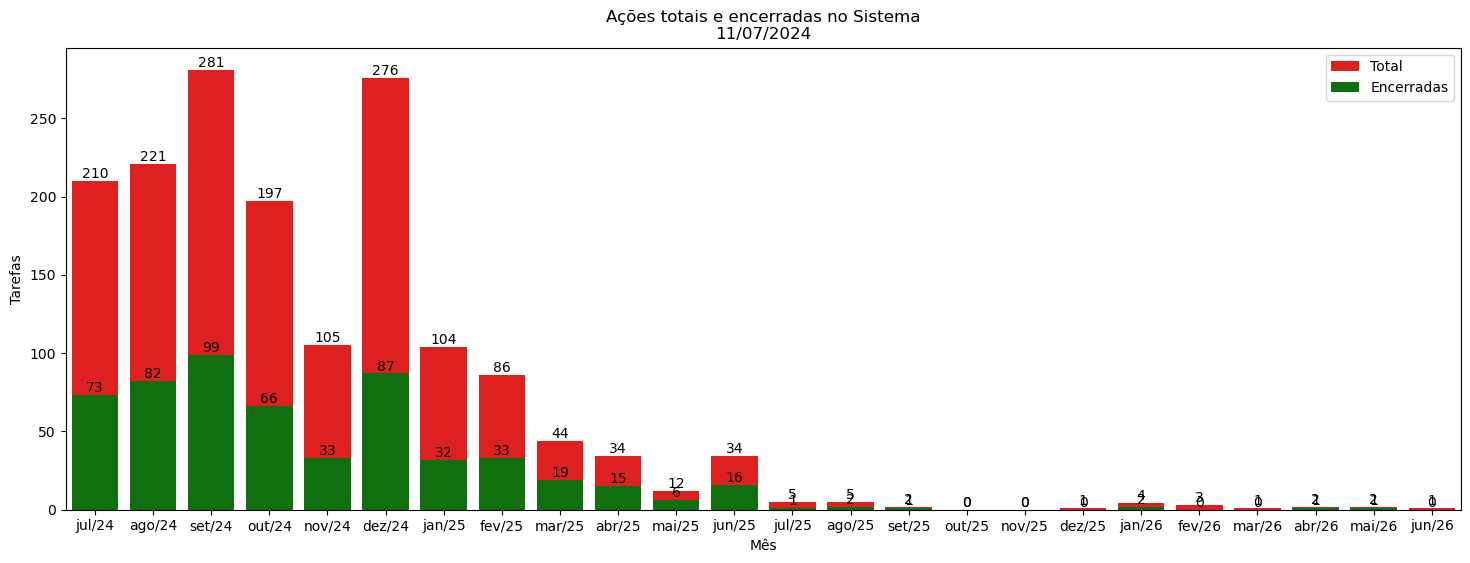

In [9]:
#Mostrando o gráfico
plt.figure(figsize=(18,6))

ax = sns.barplot(data=df_kpi, x='Mês', y='Tarefas', color='red', label='Total')
ax2 = sns.barplot(data=df_kpi, x='Mês', y='Encerradas', color='green', label='Encerradas')

#Exibir a quantidade de tarefas em cada barra
ax.bar_label(ax.containers[0])
ax2.bar_label(ax2.containers[1])

#Aplica configurações do gráfico, como rótulo do eixo Y, título do gráfico
plt.ylabel('Tarefas')
plt.title('Ações totais e encerradas no Sistema\n' + str(current_month.strftime('%d/%m/%Y')))
plt.legend()

#Salva o relatório
plt.savefig('Relatórios/' + str(current_month.date()) + ' - Geral.png')

In [10]:
#Criando um novo DataFrame para agrupar por mês TODAS as ações separando também por usuário
df_kpi = df_new.groupby([pd.Grouper(key='Planejado', freq='M'), pd.Grouper(key='Nome')]).agg({'Identificador': 'count'})
df_kpi.reset_index(inplace=True)

#Renomeando as colunas para ficar mais intuitivo
df_kpi.rename(columns={'Planejado': 'Mês', 'Identificador': 'Tarefas'}, inplace=True)

#Seta as variáveis para encontrar o mês atual e o último mês de interesse, considerando um período de 2 anos (24 meses)
current_month = pd.Timestamp.today()
last_month = pd.Timestamp.today() + pd.tseries.offsets.DateOffset(months=24)

#Remove todos os registros que não estão no período de interesse
df_kpi = df_kpi[(df_kpi['Mês'] >= current_month) & (df_kpi['Mês'] < last_month)]
df_kpi['Mês'] = df_kpi['Mês'].dt.strftime('%b/%y')

df_kpi.head()

,Mês,Nome,Tarefas
1,jul/24,Artur Lima Fonseca,33
2,jul/24,Bruna Fernandes Silva,14
3,jul/24,Clara Batista Tavares,36
4,jul/24,Flávia Gomes Pereira,12
5,jul/24,Giovana Mendes Ribeiro,24


C:\Users\gabriel.vezali\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


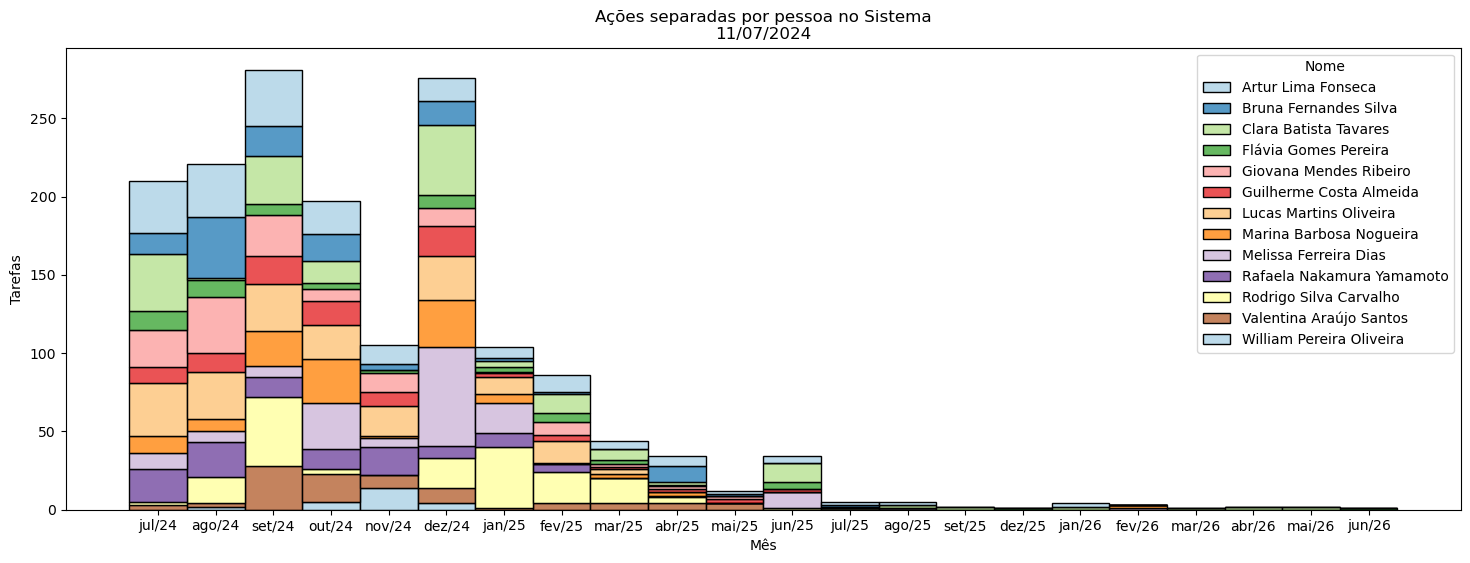

In [11]:
plt.figure(figsize=(18,6))

ax = sns.histplot(data=df_kpi, x='Mês', weights='Tarefas', hue='Nome', multiple='stack', palette='Paired')

#Exibir a quantidade de tarefas em cada bloco (PESQUISAR COMO FAZER)
#ax.bar_label(ax.containers[1])

#Aplica configurações do gráfico, como rótulo do eixo Y, título do gráfico
plt.ylabel('Tarefas')
plt.title('Ações separadas por pessoa no Sistema\n' + str(current_month.strftime('%d/%m/%Y')))

#Salva o relatório
plt.savefig('Relatórios/' + str(current_month.date()) + ' - Por Pessoa.png')